In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
import torch
from torch import nn
import pandas as pd
import torchvision.transforms as T
from torch.utils.data import TensorDataset
import pickle
import io

In [2]:
import os, sys
root_path = root_path = os.path.realpath('../')
try:
    import ego_allo_rnns
except ModuleNotFoundError:
    sys.path.append(root_path)
    # sys.path.append(os.path.join(root_path, "ego_allo_rnns"))
from ego_allo_rnns.utils.utils import front_frame, input_frame, input_label

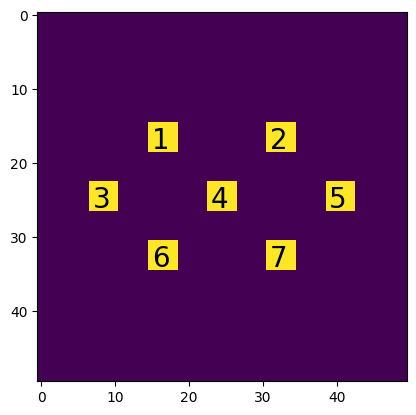

In [3]:
xy = np.zeros((50,50))
width =5
x_locs = np.array([16,32,8,24,40,16,32])+1
y_locs = np.array([16,16,24,24,24,32,32])+1
for x,y in zip(x_locs, y_locs):
    xy[x-width//2:x+width//2,y-width//2:y+width//2] = 1

plt.imshow(xy.T)
for i,(x,y) in enumerate(zip(x_locs,y_locs)):
    plt.text(x-2,y+1,str(i+1),fontdict={'fontsize':20,'color':'k'})

In [4]:
trial_types = np.array([
    [(0,2),(1,3),(3,5),(4,6)],
    [(0,3),(1,4),(2,5),(3,6)],
    [(1,0),(3,2),(4,3),(6,5)], 
    [(0,1),(2,3),(3,4),(5,6)],
    [(3,0),(4,1),(5,2),(6,3)],
    [(2,0),(3,1),(5,3),(6,4)]])
direction_colors = ["royalblue","darkred","dodgerblue","indianred","lightblue","pink"]
location_colors = ["palegreen","lightsalmon","mediumseagreen","olive","goldenrod","green","sienna"]

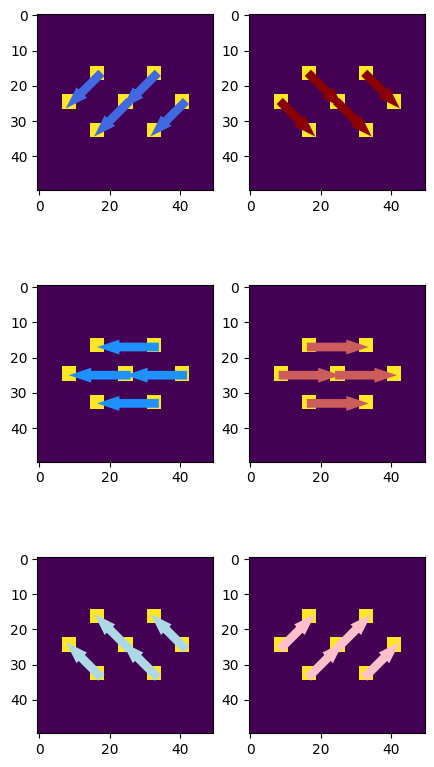

In [5]:
f,axs = plt.subplots(3,2,figsize=(5,10))
axs = axs.ravel()
for i,(ax,col) in enumerate(zip(axs,direction_colors)):    
    ax.imshow(xy.T)
    for dirs in range(4):
        t = trial_types[i,dirs,:]
        ax.arrow(x_locs[t[0]],y_locs[t[0]],(x_locs[t[1]]-x_locs[t[0]])*0.7,(y_locs[t[1]]-y_locs[t[0]])*0.7,color=col,width=0.5,linewidth=5)
    



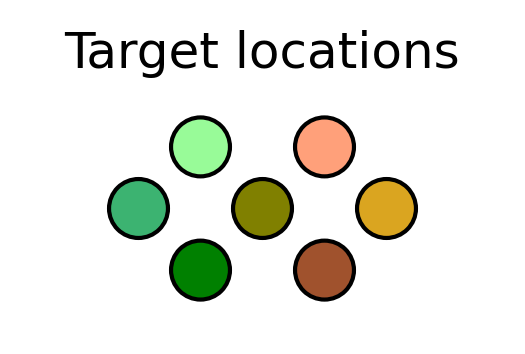

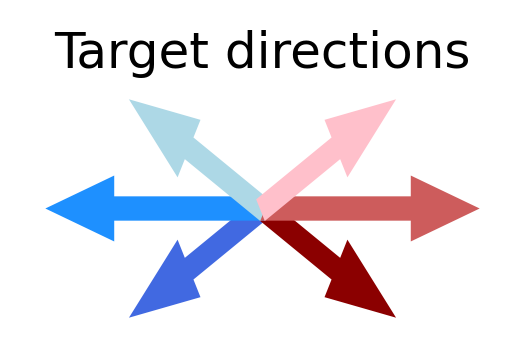

In [6]:
plt.figure(figsize=(2,1),dpi=300)
plt.scatter(x_locs,y_locs[::-1],s=200,edgecolors='k',facecolors=location_colors)
plt.title("Target locations")
ax = plt.gca()
ax.set_axis_off()
ax.set_xlim(-5,55)
ax.set_ylim(10,40)

plt.figure(figsize=(2,1),dpi=300)
y_locs_flip = y_locs[::-1]
for i,col in enumerate(direction_colors):
        t = trial_types[i,0,:]        
        plt.arrow(0,0,(x_locs[t[1]]-x_locs[t[0]])*0.7,(y_locs_flip[t[1]]-y_locs_flip[t[0]])*0.4,color=col,linewidth=1.2,width=1)
plt.title("Target directions")
ax = plt.gca()
ax.set_axis_off()

In [7]:
# trial type matrix: start_loc_id, target_loc_id, target_direction_id, start_loc_x, start_loc_y, target_loc_x, target_loc_y, target_loc_color,target_direction_color
# location ids: enumerate row by row (as defined in trial_types)
# direction ids: enumerate row by row (as shown in subplots above)
header = ["start_loc_id", "target_loc_id", "target_direction_id", "start_loc_x", "start_loc_y", "target_loc_x", "target_loc_y", "target_loc_color","target_direction_color"]
rows = []
for i,dc in enumerate(direction_colors): #for each motion direction
    for j in range(4): # for each trial of that direction
        # add pairs of start and goal locations
        idces = trial_types[i,j,:]
        rows.append([idces[0],idces[1],i,x_locs[idces[0]],y_locs[idces[0]],x_locs[idces[1]],y_locs[idces[1]],location_colors[idces[1]],dc])
df = pd.DataFrame(np.asarray(rows),columns=header)
cs = header[:-2]
cs
for c in cs:
    df[c] = df[c].astype("int32")
df

,start_loc_id,target_loc_id,target_direction_id,start_loc_x,start_loc_y,target_loc_x,target_loc_y,target_loc_color,target_direction_color
0,0,2,0,17,17,9,25,mediumseagreen,royalblue
1,1,3,0,33,17,25,25,olive,royalblue
2,3,5,0,25,25,17,33,green,royalblue
3,4,6,0,41,25,33,33,sienna,royalblue
4,0,3,1,17,17,25,25,olive,darkred
5,1,4,1,33,17,41,25,goldenrod,darkred
6,2,5,1,9,25,17,33,green,darkred
7,3,6,1,25,25,33,33,sienna,darkred
8,1,0,2,33,17,17,17,palegreen,dodgerblue
9,3,2,2,25,25,9,25,mediumseagreen,dodgerblue


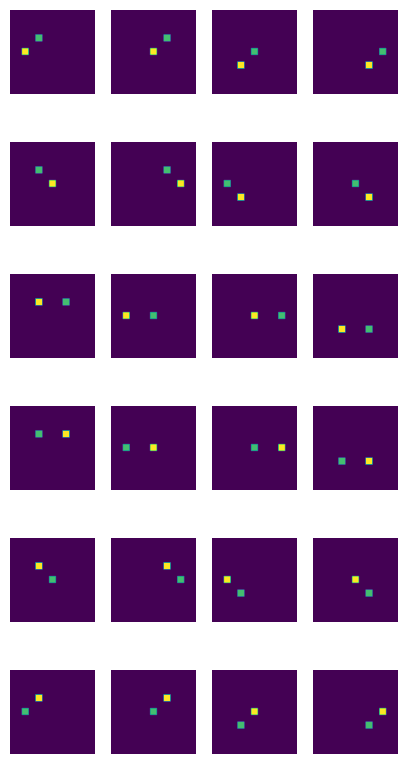

In [8]:
# verify that trial indices are correct: generate example inputs for all conditions shown above:
width = 5
f, axs = plt.subplots(6,4,figsize=(5,10))
axs = axs.flatten()
for i,ax in enumerate(axs):
    xy = np.zeros((50,50))
    x_start = df["start_loc_x"][i]    
    y_start = df["start_loc_y"][i]
    x_target = df["target_loc_x"][i]
    y_target = df["target_loc_y"][i]
    # add start and target:
    xy[x_start-width//2:x_start+width//2,y_start-width//2:y_start+width//2] = 0.7
    xy[x_target-width//2:x_target+width//2,y_target-width//2:y_target+width//2] = 1
    ax.imshow(xy.T)
    ax.set_axis_off()

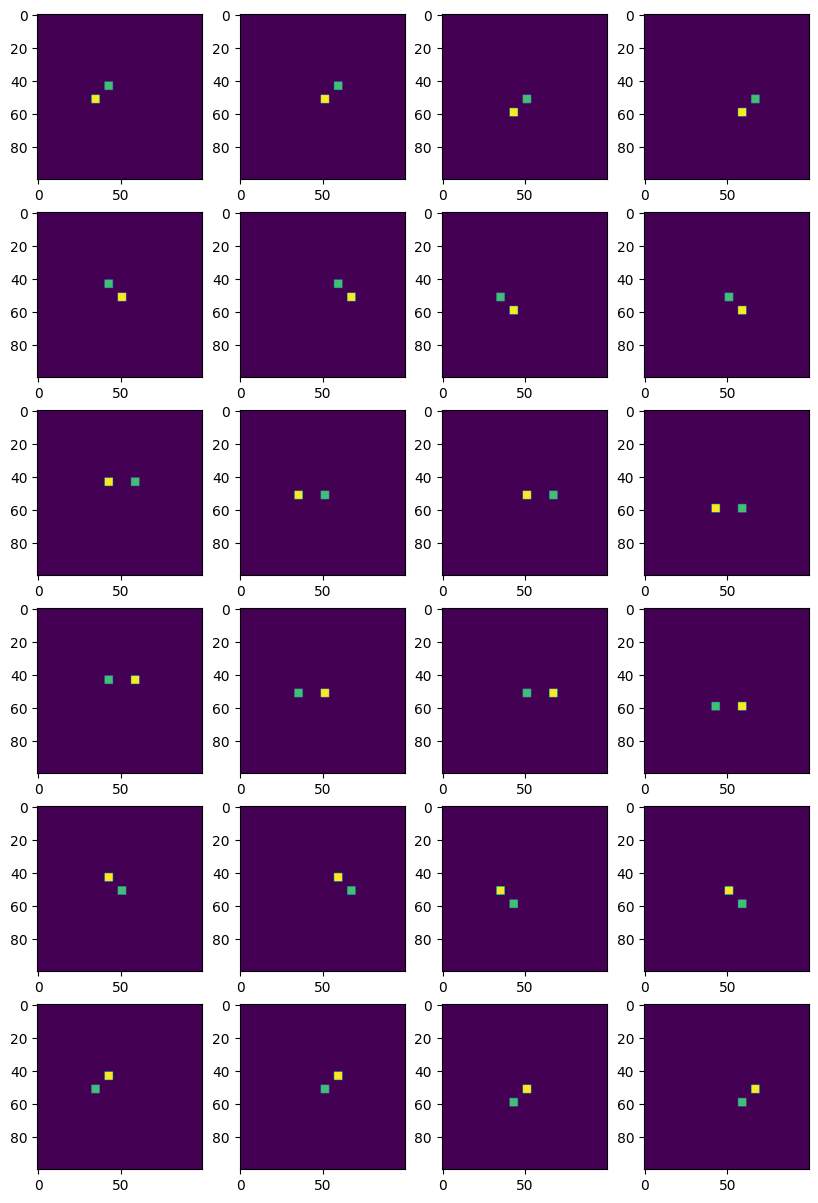

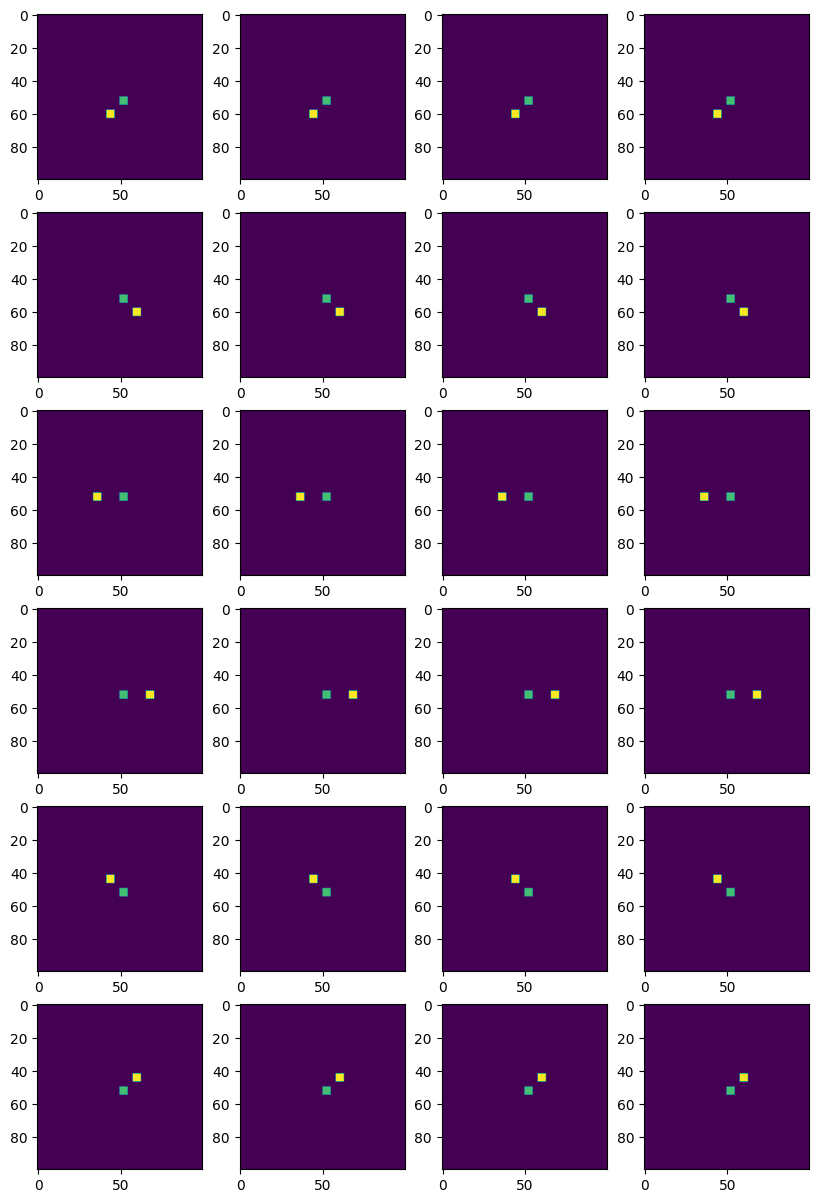

In [13]:

start_coord = df[["start_loc_y","start_loc_x"]].to_numpy().T
target_coord = df[["target_loc_y","target_loc_x"]].to_numpy().T
f,s,t = front_frame(frame_amount=start_coord.shape[1],start_coordinate=start_coord,target_coordinate=target_coord,bbox_intensity=0.0,noise_intensity=0)

_, axs = plt.subplots(6,4,figsize=(10,15))
axs = axs.flatten()
frames = input_frame(f, input_type="WC")
for i,ax in enumerate(axs):
    ax.imshow(frames[i,:,:])



_, axs = plt.subplots(6,4,figsize=(10,15))
axs = axs.flatten()
frames = input_frame(f, input_type="SC",start_poke=s)
for i,ax in enumerate(axs):
    ax.imshow(frames[i,:,:])


In [ ]:
import torchvision
torchvision.__version__

In [ ]:
torch.cuda.is_available()

In [ ]:
# now make test data (x,y pairs, all WC/SC combinations)
size_ds = 40
input_type = "WC"
output_type = "WC"
label_type = "Cartesian"
n_frames = 11
target_frame = (4, 4) # sample bounds of location of target in frame sequence
size_ds = size_ds or 100
resize = T.Resize(size_ds, interpolation=T.InterpolationMode.NEAREST, antialias=False)

# front frames
start_coord = df[["start_loc_y", "start_loc_x"]].to_numpy().T
target_coord = df[["target_loc_y", "target_loc_x"]].to_numpy().T
n_trials = start_coord.shape[1]

frames, start_poke_coordinate, target_poke_coordinate = front_frame(
    random_seed=123,
    frame_amount=n_trials,
    start_coordinate=start_coord,
    target_coordinate=target_coord,
    show_target=False
)
x_test_notarget = input_frame(
        frames, input_type=input_type, start_poke=start_poke_coordinate
    )
x_test_notarget = resize(torch.tensor(x_test_notarget)).numpy()

frames, start_poke_coordinate, target_poke_coordinate = front_frame(
    random_seed=123,
    frame_amount=n_trials,
    start_coordinate=start_coord,
    target_coordinate=target_coord,
    show_target=True
)
x_test_withtarget = input_frame(
        frames, input_type=input_type, start_poke=start_poke_coordinate
    )
x_test_withtarget = resize(torch.tensor(x_test_withtarget)).numpy()


x_test = np.repeat(x_test_notarget[:, np.newaxis, :, :], n_frames, axis=1)

targets = np.random.uniform(
        target_frame[0], target_frame[1] + 1, size=n_frames
    ).astype(int)
for i, t in enumerate(targets):
    # slot in frame with target
    x_test[i, t, :, :] = x_test_withtarget[i, :, :]


In [ ]:
dims = x_test.shape
x_test = torch.tensor(x_test.reshape((*dims[:2], dims[-1] ** 2)), dtype=torch.float)
y_test = torch.tensor(
    input_label(
        start_poke_coordinate, target_poke_coordinate, output_type, label_type
    ),
    dtype=torch.float,
)
data_test = TensorDataset(x_test, y_test)

In [ ]:
from ego_allo_rnns.data.EgoVsAllo import make_testset_from_conditions

df, data_test = make_testset_from_conditions(random_seed=444)
x = data_test[1][0]
_,axs = plt.subplots(4,3,figsize=(15,15))
axs = axs.flatten()
for i, xi in enumerate(x):
    axs[i].imshow(xi.reshape((40,40)),vmax=1)
    axs[i].set_title(f"frame {i+1}")
axs[-1].set_axis_off()
    

In [ ]:
# inference: load model and pass data through
with open("../checkpoints/run_WCWC_1/model.pkl","rb") as f:
    rnn = pickle.load(f)

In [ ]:
# class CPU_Unpickler(pickle.Unpickler):
#     """from https://stackoverflow.com/questions/56369030/runtimeerror-attempting-to-deserialize-object-on-a-cuda-device

    
#     """
#     def find_class(self, module, name):
#         if module == 'torch.storage' and name == '_load_from_bytes':
#             return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
#         else: return super().find_class(module, name)
# with open("../checkpoints/run_WCWC_1/model.pkl","rb") as f:
#     rnn = CPU_Unpickler(f).load()

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = []
ground_truth = []
hidden_activity = []
rnn.to(device)
for x,y in data_test:
    y_ = rnn.forward(x.reshape(1,11,1600).to(device))
    y_ = y_.to("cpu").detach().numpy()
    predictions.append(y_)
    ground_truth.append(y.to("cpu").detach().numpy())
    hidden_activity.append(rnn.ro.to("cpu").detach().numpy())
ground_truth = np.asarray(ground_truth)
predictions = np.asarray(predictions).squeeze()
hidden_activity = np.asarray(hidden_activity).squeeze()

In [ ]:
hidden_activity.shape

In [ ]:
plt.scatter(ground_truth.flatten(),predictions.flatten(),s=100,alpha=0.2)
plt.xlabel("ground truth")
plt.ylabel("prediction")
plt.title("WCWC")

In [ ]:
location_groups = df.groupby("target_loc_color").indices
direction_groups = df.groupby("target_direction_color").indices

In [ ]:
plt.figure()
for k,v in location_groups.items():
    hv = hidden_activity[v,:,:].mean(-1).mean(0)
    plt.plot(hv,color=k)
plt.xlabel("frame")
plt.ylabel("grand mean activity")
plt.title("WCWC")
plt.plot([4,4],plt.ylim(),"k-")

In [ ]:
from sklearn.decomposition import PCA